In [1]:
import mdtraj as md
import numpy as np
import plotly.graph_objs as go
import os
import pandas as pd
import matplotlib.pyplot as plt
import concurrent.futures
from scipy.spatial import distance_matrix
from scipy.special import sph_harm
from tqdm import tqdm

def plot_atoms(coordinates, values, x, filename="", cmap='Viridis' ):
    """
    plots a set of coordinates and colors them according to corresponding list of values 
    """

    #Slice the coordinates and values to include only the first 'x' atoms
    coordinates = coordinates[:, :x]  # Keep the first 'x' columns
    values = values[:x]  # Keep the first 'x' values

    # Create a 3D scatter plot using plotly for interactive visualization
    scatter = go.Scatter3d(
        x=coordinates[0], 
        y=coordinates[1], 
        z=coordinates[2], 
        mode='markers',
        marker=dict(
            size=7,
            color=values,
            colorscale=cmap,  # Colormap
            colorbar=dict(
                title='Value',
                len=0.7,  # Reduce the length of the colorbar relative to the plot
                thickness=15,  # Make the colorbar thinner
            ),
            opacity=0.8
        )
    )

    #Define the layout for the plot
    layout = go.Layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube',  # Keeps the axes proportional (e.g., same scale for all axes)
        ),
        
        width=800,  # Adjust overall figure width
        height=600,  # Adjust overall figure height
        margin=dict(l=0, r=0, b=0, t=0),  # Reduce margins to allow for a larger plot area
    )

    #Show Figure
    fig = go.Figure(data=[scatter], layout=layout)

    #Save Figure
    if filename != "":
        fig.write_image(f"{filename}.svg")

    fig.show()


def plot_atoms_static(coordinates, values, x, filename="", cmap='viridis'):
    """
    Plots a set of coordinates and colors them according to corresponding list of values
    in a static Matplotlib plot.
    """

    # Slice the coordinates and values to include only the first 'x' atoms
    coordinates = coordinates[:, :x]  # Keep the first 'x' columns
    values = values[:x]  # Keep the first 'x' values

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot with colormap
    scatter = ax.scatter(
        coordinates[0], coordinates[1], coordinates[2], 
        c=values, cmap=cmap, s=80, marker='o', depthshade=False
    )

    # # Add a color bar with title and customization
    # colorbar = fig.colorbar(scatter, ax=ax, shrink=0.7, aspect=15)
    # colorbar.set_label(r'$Q_6 > 0.5$', fontsize=14)

    # Set labels and plot settings
    ax.set_xlabel("X", weight='bold')
    ax.set_ylabel("Y", weight='bold')
    ax.set_zlabel("Z", weight='bold')
    ax.set_box_aspect([1, 1, 1])  # Equal scaling for all axes

    # Adjust margins for a larger plot area
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

    # Save the figure if a filename is provided
    if filename:
        plt.savefig(f"{filename}.svg", format='svg',dpi=300, bbox_inches='tight')

    # Display the plot
    plt.show()


def plot_spherical_harmonic(l, m, filename="", res=100):
    """
    Plot the magnitude of the spherical harmonic Y_lm on a unit sphere with color mapping, without edges.
    
    Parameters:
    l (int): Degree of the spherical harmonic.
    m (int): Order of the spherical harmonic.
    """
    # Define the spherical coordinates
    theta = np.linspace(0, np.pi, res)  # polar angle
    phi = np.linspace(0, 2 * np.pi, res)  # azimuthal angle
    theta, phi = np.meshgrid(theta, phi)

    # Compute the spherical harmonics Y_lm
    Y_lm = sph_harm(m, l, phi, theta)

    # Convert to Cartesian coordinates on a unit sphere
    x_unit = np.sin(theta) * np.cos(phi)
    y_unit = np.sin(theta) * np.sin(phi)
    z_unit = np.cos(theta)

    # Create the 3D plot with colors denoting the magnitude of the spherical harmonics and no edges
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface with color mapping to the magnitude of Y_lm and no edges
    surface = ax.plot_surface(
        x_unit, y_unit, z_unit, rstride=1, cstride=1,
        facecolors=plt.cm.seismic(np.abs(Y_lm)/np.max(np.abs(Y_lm))), 
        edgecolor='none', alpha=0.9
    )

    # ax.set_title(f'$|Y_{l}^{m}|$ on Unit Sphere', fontsize=16)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Add a color bar to show the magnitude scale
    magnitude_map = plt.cm.ScalarMappable(cmap='seismic')
    magnitude_map.set_array(np.abs(Y_lm))
    fig.colorbar(magnitude_map, ax=ax, shrink=0.5, aspect=10, label="Magnitude")

    #Save Figure
    if filename != "":
        plt.savefig(f"{filename}.png", dpi=300)

    plt.show()


def load_coordinates(gro, xtc, frame_number):
    """
    Extracts the coordinates of the CA atoms from a given trajectory frame
    """

    #Load the specific frame using MDTraj
    traj = md.load(xtc, top=gro, frame=frame_number)

    #Select only CA atoms (alpha carbons)
    ca_atoms = traj.topology.select("name CA")

    #Create a new trajectory object containing only the CA atoms
    ca_traj = traj.atom_slice(ca_atoms)

    #Extract coordinates of CA atoms (from the first and only frame, so we use index 0)
    coordinates = ca_traj.xyz[0].T  # Transpose to separate x, y, z coordinates

    #Extract box sizes of current frame
    box_length = ca_traj.unitcell_lengths[0]

    return coordinates, box_length


def compute_neighbor_vectors(coords, box, adjacency_matrix):
    """
    Compute the neighbor vectors for each atom in the system considering periodic boundary conditions (PBC).
    
    Parameters:
        coords (np.ndarray): Array of shape (n_atoms, 3) containing the coordinates of the atoms.
        box (np.ndarray): Array of shape (3,) containing the box dimensions for PBC.
        adjacency_matrix (np.ndarray): Array of shape (n_atoms, n_atoms), where 1 indicates atoms are neighbors.
    
    Returns:
        list of np.ndarray: List where each element contains the bond vectors (n_neighbors, 3) for each atom.
    """
    #Compute pairwise displacement matrix
    n_atoms = coords.shape[0]
    
    #Calculate all pairwise displacements using broadcasting
    displacements = coords[:, np.newaxis, :] - coords[np.newaxis, :, :]
    
    #Apply periodic boundary conditions
    displacements -= box * np.round(displacements / box)
    
    #Mask out non-neighbors using the adjacency matrix (neighbors indicated by 1)
    neighbor_vectors = [displacements[i][adjacency_matrix[i] == 1] for i in range(n_atoms)]
    
    return neighbor_vectors


def compute_q6(neighbor_vectors, l=6):
    """
    Compute the normalized q6 vectors for all atoms in the system using vectorization.
    
    Parameters:
        neighbor_vectors (list of np.ndarray): A list where each element contains the bond vectors 
                                               (n_neighbors, 3) for each atom.
        l (int): Degree of spherical harmonics (default is 6).
    
    Returns:
        np.ndarray: An array of normalized q6 vectors for all atoms, shape (n_atoms, 2l+1).
    """
    n_atoms = len(neighbor_vectors)
    q6_vectors = np.zeros((n_atoms, 2 * l + 1), dtype=complex)  # Store q6 vector for each atom
    
    #Loop over all atoms
    for i, neighbors in enumerate(neighbor_vectors):
        if neighbors.size == 0:
            continue  # Skip if no neighbors

        #Vectorized spherical coordinate calculation
        r = np.linalg.norm(neighbors, axis=1)
        theta = np.arccos(neighbors[:, 2] / r)
        phi = np.arctan2(neighbors[:, 1], neighbors[:, 0])
        
        #Compute all spherical harmonics at once
        m_values = np.arange(-l, l + 1)
        Y_lm = np.array([sph_harm(m, l, phi, theta) for m in m_values])  # Shape (2l+1, n_neighbors)
        
        #Sum the spherical harmonics for each atom and normalize
        q6_vectors[i, :] = np.sum(Y_lm, axis=1) 
        q6_vectors[i, :] /= np.sqrt(np.sum(np.abs(q6_vectors[i, :])**2))  # Normalize the q6 vector
    
    return q6_vectors


def compute_local_q6(q6_vectors, adjacency_matrix, dist_matrix, cutoff):
    """
    Compute the local Steinhardt Q6 parameter for all atoms in a vectorized manner.
    
    Parameters:
        q6_vectors (np.ndarray): Array of normalized q6 vectors for all atoms, shape (n_atoms, 2l+1).
        adjacency_matrix (np.ndarray): Adjacency matrix indicating neighbors (n_atoms, n_atoms).
        dist_matrix (np.ndarray): Pairwise distance matrix (n_atoms, n_atoms).
        cutoff (float): Distance cutoff for the neighbor interaction.
    
    Returns:
        np.ndarray: An array of local Q6 values for all atoms, shape (n_atoms,).
    """
    #Mask out distances larger than the cutoff
    neighbor_mask = (dist_matrix <= cutoff) & (adjacency_matrix == 1)
    
    #Compute the dot products of q6 vectors for all atoms
    q6_dot_products = np.real(np.einsum('ik,jk->ij', q6_vectors, np.conjugate(q6_vectors)))
    
    #Apply the neighbor mask to the dot products
    q6_weighted_dot_products = q6_dot_products * neighbor_mask
    
    #Compute the numerator (sum of weighted dot products) and denominator (number of neighbors)
    numerator = np.sum(q6_weighted_dot_products, axis=1)
    denominator = np.sum(neighbor_mask, axis=1)
    
    #Prevent division by zero
    denominator[denominator == 0] = 1
    
    #Compute the final local Q6 values
    local_q6_values = numerator / denominator #Normalized localq6 value
    # local_q6_values = numerator # Unnormallized localq6 value
    
    return local_q6_values


def pbc_distance_matrix(coords, box_length):
    """
    Compute the pairwise distance matrix with periodic boundary conditions.

    Parameters:
    coords: array_like
        The coordinates of the points (shape: [N, 3]).
    box_length: array_like
        The box lengths in each dimension (shape: [3] for x, y, z).
    
    Returns:
    dist_matrix: array_like
        Pairwise distance matrix with PBC applied (shape: [N, N]).
    """

    #Get number of atoms in the system
    num_atoms = len(coords)

    #Initialize the distance matrix
    dist_matrix = np.zeros((num_atoms, num_atoms))

    #Fill each element in the matrix
    for i in range(num_atoms):
        for j in range(i + 1, num_atoms):
            delta = coords[i] - coords[j]
            #Apply minimum image convention
            delta = delta - box_length * np.round(delta / box_length)
            dist = np.sqrt(np.sum(delta ** 2))
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist  # Symmetric matrix
    
    return dist_matrix


def compute_adjacency_matrix(coordinates, cutoff, atom_values, box, PBC=True):
    """
    Computes an adjacency matrix where the value is 1 for atom pairs within the cutoff distance, and 0 otherwise.

    Parameters:
        coordinates (np.ndarray): Array of shape (n_atoms, 3) containing the coordinates of the atoms.
        cutoff (float): Distance threshold for determining adjacency.

    Returns:
        np.ndarray: Adjacency matrix of shape (n_atoms, n_atoms), with 1 indicating atoms are within the cutoff distance.
    """
    
    #Transpose the coordinates
    coordinates = coordinates.T

    #Check if Periodic Boundary Conditions need to be taken into account
    if PBC:
        #Compute the periodic pairwise distance matrix
        dist_matrix = pbc_distance_matrix(coordinates, box)
    else:
        #Compute the pairwise distance matrix
        dist_matrix = distance_matrix(coordinates, coordinates)

    #Create an adjacency matrix where 1 indicates distance <= cutoff, else 0
    adjacency_matrix = (dist_matrix <= cutoff).astype(int)

    #Set the diagonal to 0 (since an atom is not adjacent to itself)
    np.fill_diagonal(adjacency_matrix, 0)

    #Remove atoms that are not crystalline (lq6 < 1)
    crystal_filter = np.outer(atom_values, atom_values)
    final_matrix = adjacency_matrix * crystal_filter

    return final_matrix


def dfs(node, adj_matrix, visited, cluster):
    """
    Perform DFS to find all nodes connected to the given node.

    Parameters:
        node (int): The current node to start DFS from.
        adj_matrix (np.ndarray): The adjacency matrix representing the graph.
        visited (set): A set of nodes that have already been visited.
        cluster (list): The current cluster being formed.
    """
    visited.add(node)
    cluster.append(node)

    #Traverse all neighbors of the current node
    for neighbor, is_connected in enumerate(adj_matrix[node]):
        if is_connected == 1 and neighbor not in visited:
            dfs(neighbor, adj_matrix, visited, cluster)


def find_clusters(adj_matrix):
    """
    Find clusters in the graph using DFS.

    Parameters:
        adj_matrix (np.ndarray): The adjacency matrix representing the graph.
    
    Returns:
        list of list: A list of clusters, where each cluster is a list of nodes.
    """
    visited = set()
    clusters = []

    #Iterate through each node in the graph
    for node in range(len(adj_matrix)):
        if node not in visited:
            #If the node is not visited, start a new cluster
            cluster = []
            dfs(node, adj_matrix, visited, cluster)
            clusters.append(cluster)

    return clusters


def process_crystal_frame(topology_file, trajectory_file, frame_number, d_cutoff, lq6_cutoff):
    """Processes a single frame and returns the largest cluster size."""

    #Extract the coordinates of CA atom for this frame
    coords, box = load_coordinates(topology_file, trajectory_file, frame_number)

    #Get the periodic pairwise distances between atoms matrix
    dist_matrix = pbc_distance_matrix(coords.T, box)

    #Create an adjacency matrix where 1 indicates distance <= cutoff, else 0
    adjacency_matrix = (dist_matrix <= d_cutoff).astype(int)

    #Set the diagonal to 0 (since an atom is not adjacent to itself)
    np.fill_diagonal(adjacency_matrix, 0)

    #Compute the neighbor vectors for each atom
    neighbor_vectors = compute_neighbor_vectors(coords.T, box, adjacency_matrix)

    #Compute Q6 for each atom
    q6_vectors = compute_q6(neighbor_vectors)

    #Compute Local Q6 for each atom
    local_q6_values = compute_local_q6(q6_vectors, adjacency_matrix, dist_matrix, d_cutoff)

    #Select only atoms for which lq6 is high enough
    values_cutoff = np.where(local_q6_values > lq6_cutoff, 1, 0)

    #Remove atoms from adjacency matrix that are not crystalline (select crystal neighbors)
    crystal_filter = np.outer(values_cutoff, values_cutoff)
    crystal_matrix = adjacency_matrix * crystal_filter

    #Find clusters within connected crystal atoms
    clusters = find_clusters(crystal_matrix)

    #Select largest cluster
    largest_cluster = max(clusters, key=len)

    return len(largest_cluster)


def calculate_crystal_sizes(topology_file, trajectory_file, min_frame, max_frame, stride, lq6_cutoff, d_cutoff, PBC=True, num_workers=None):
    """Tracks the size of the largest crystal for frames within a trajectory (parallelized)."""

    # Store results as tuples of (frame_number, cluster_size)
    results = []

    # Set up a ThreadPoolExecutor for parallel execution
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        # Prepare a list of tasks for each frame
        futures = {
            executor.submit(
                process_crystal_frame,
                topology_file, trajectory_file, frame_number, d_cutoff, lq6_cutoff
            ): frame_number
            for frame_number in range(min_frame, max_frame, stride)
        }

        # Collect results as they are completed
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
            frame_number = futures[future]  # Retrieve the frame number associated with this future
            cluster_size = future.result()  # Get the result (cluster size) for this frame
            results.append((frame_number, cluster_size))

    # Sort the results by frame number to ensure the correct order
    results_sorted = sorted(results, key=lambda x: x[0])

    # Extract the cluster sizes in the correct order
    cluster_size = np.array([result[1] for result in results_sorted])

    # Use the same name as input file for the output
    output_file = trajectory_file.replace('.xtc', '')

    # Save the crystal sizes as .npy file
    np.save(f'{output_file}_crystal_sizes', cluster_size)

    return cluster_size


def process_droplet_frame(topology_file, trajectory_file, frame_number, d_cutoff, lq6_cutoff):
    """Processes a single frame and returns the largest cluster size."""

    #Extract the coordinates of CA atom for this frame
    coords, box = load_coordinates(topology_file, trajectory_file, frame_number)

    #Get the periodic pairwise distances between atoms matrix
    dist_matrix = pbc_distance_matrix(coords.T, box)

    #Create an adjacency matrix where 1 indicates distance <= cutoff, else 0
    adjacency_matrix = (dist_matrix <= d_cutoff).astype(int)

    #Set the diagonal to 0 (since an atom is not adjacent to itself)
    np.fill_diagonal(adjacency_matrix, 0)

    #Compute the neighbor vectors for each atom
    neighbor_vectors = compute_neighbor_vectors(coords.T, box, adjacency_matrix)

    #Compute Q6 for each atom
    q6_vectors = compute_q6(neighbor_vectors)

    #Compute Local Q6 for each atom
    local_q6_values = compute_local_q6(q6_vectors, adjacency_matrix, dist_matrix, d_cutoff)

    #Select only atoms for which lq6 is high enough
    values_cutoff = np.where(local_q6_values < lq6_cutoff, 1, 0)

    #Remove atoms from adjacency matrix that are not crystalline (select crystal neighbors)
    crystal_filter = np.outer(values_cutoff, values_cutoff)
    crystal_matrix = adjacency_matrix * crystal_filter

    #Find clusters within connected crystal atoms
    clusters = find_clusters(crystal_matrix)

    #Select largest cluster
    largest_cluster = max(clusters, key=len)

    return len(largest_cluster)


def calculate_droplet_sizes(topology_file, trajectory_file, min_frame, max_frame, stride, lq6_cutoff, d_cutoff, PBC=True, num_workers=None):
    """Tracks the size of the largest crystal for frames within a trajectory (parallelized)."""

    # Store results as tuples of (frame_number, cluster_size)
    results = []

    # Set up a ThreadPoolExecutor for parallel execution
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        # Prepare a list of tasks for each frame
        futures = {
            executor.submit(
                process_droplet_frame,
                topology_file, trajectory_file, frame_number, d_cutoff, lq6_cutoff
            ): frame_number
            for frame_number in range(min_frame, max_frame, stride)
        }

        # Collect results as they are completed
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
            frame_number = futures[future]  # Retrieve the frame number associated with this future
            cluster_size = future.result()  # Get the result (cluster size) for this frame
            results.append((frame_number, cluster_size))

    # Sort the results by frame number to ensure the correct order
    results_sorted = sorted(results, key=lambda x: x[0])

    # Extract the cluster sizes in the correct order
    cluster_size = np.array([result[1] for result in results_sorted])

    # Use the same name as input file for the output
    output_file = trajectory_file.replace('.xtc', '')

    # Save the crystal sizes as .npy file
    np.save(f'{output_file}_droplet_sizes', cluster_size)

    return cluster_size


# Plot Crystal Clusters Per Frame

The cell below computes the local steinhardt Q6 parameter and uses it to identify crystals within a given frame of a molecular trajectory. Crystal clusters are highlighted in the plot.

In [116]:
#Load the trajecory
topology_file = 'Trajectories/1.7nm/gamma_glycine_crystal_3_2_3_box_5.0_1.7nm_sphere_insert_303_solv_minim_npteq275K.gro'  # or .pdb, .tpr, etc.
trajectory_file = 'Trajectories/1.7nm/gamma_glycine_crystal_3_2_3_box_5.0_1.7nm_sphere_insert_303_solv_minim_npteq275K_md_run10_short.xtc'  # or .trr, etc.

#Load specific frame for trajectory
frame_number = 0
lq6_cutoff = 0.5
d_cutoff = 0.6

# #Extract the coordinates of CA atom for this frame
# coords, box = load_coordinates(topology_file, trajectory_file, frame_number)

gro_file = "Trajectories/gamma_glycine_crystal_3_2_3_box_5.0_1.7nm_sphere_insert_303.gro"

# Load the .gro file as an MDTraj object
traj = md.load(gro_file)
#Select only CA atoms (alpha carbons)
ca_atoms = traj.topology.select("name CA")

#Create a new trajectory object containing only the CA atoms
ca_traj = traj.atom_slice(ca_atoms)
    
# Extract the coordinates (first frame only, since .gro files typically store a single frame)
coords = ca_traj.xyz[0].T  # Shape: (N, 3)
box = traj.unitcell_lengths[0]

#Get the periodic pairwise distances between atoms matrix
dist_matrix = pbc_distance_matrix(coords.T, box)

#Create an adjacency matrix where 1 indicates distance <= cutoff, else 0
adjacency_matrix = (dist_matrix <= d_cutoff).astype(int)

#Set the diagonal to 0 (since an atom is not adjacent to itself)
np.fill_diagonal(adjacency_matrix, 0)

#Compute the neighbor vectors for each atom
neighbor_vectors = compute_neighbor_vectors(coords.T, box, adjacency_matrix)

#Compute Q6 for each atom
q6_vectors= compute_q6(neighbor_vectors)

#Compute Local Q6 for each atom
local_q6_values = compute_local_q6(q6_vectors, adjacency_matrix, dist_matrix, d_cutoff)

#Select only atoms for which lq6 is high enough
values_cutoff = np.where(local_q6_values > lq6_cutoff, 1, 0)

#Remove atoms from adjacency matrix that are not crystalline (select crystal neighbors)
crystal_filter = np.outer(values_cutoff, values_cutoff)
crystal_matrix = adjacency_matrix * crystal_filter

#Find clusters within connected crystal atoms
clusters = find_clusters(crystal_matrix)
cluster_array = np.zeros(558, dtype=int)
largest_cluster = max(clusters, key=len)

#Initialize the cluster array with zeros (no cluster)
cluster_array = np.zeros(558, dtype=int)  # Assuming there are 558 atoms

#Sort clusters by size (largest first)
sorted_clusters = sorted(clusters, key=len, reverse=True)

#Assign unique values for clusters larger than 1 atom, with the largest cluster getting the highest value
current_value = len([c for c in sorted_clusters if len(c) > 1])  # Start with the highest value

# Assign unique value for each cluster
for cluster in sorted_clusters:
    if len(cluster) > 10:  # Only consider clusters with more than 3 atom
        cluster_array[cluster] = current_value  # Assign a unique value, largest gets the highest
        current_value -= 1  # Decrease the value for the next cluster

# cluster_array[sorted_clusters[0]] = current_value

#Illustrate cluster
plot_atoms(coords, cluster_array, 558, cmap='viridis')


In [117]:
print(len(largest_cluster))

251


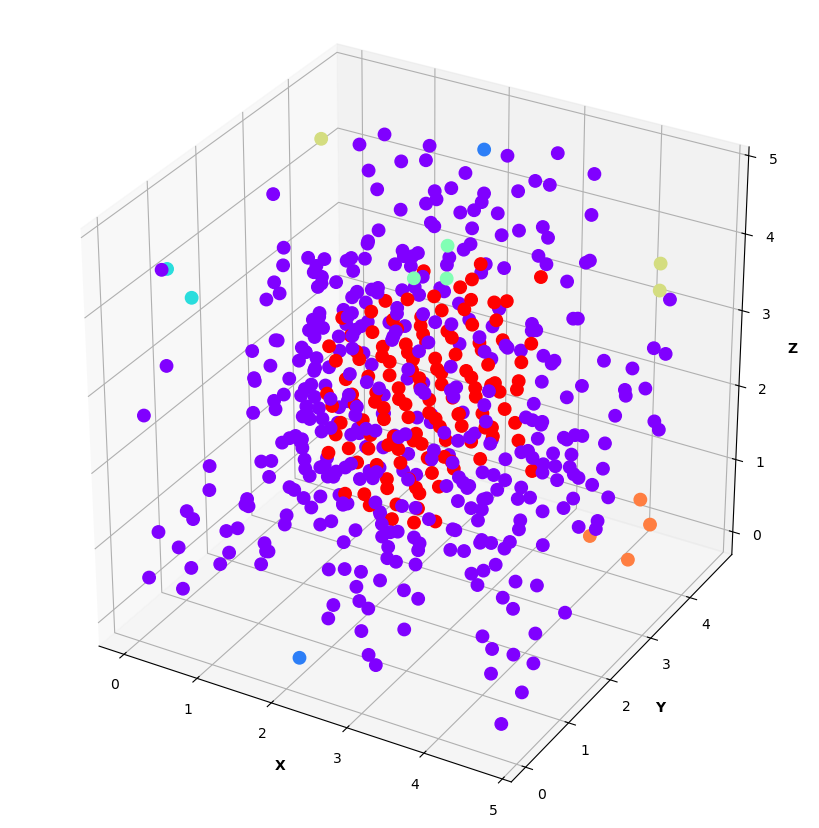

In [5]:
plot_atoms_static(coords, cluster_array, 558, cmap='rainbow', filename='Clusters_crystal.svg')

# Plot Crystal Size Over Time

This cell computes the size of the largest crystal in the system for every frame of a molecular directory and plots it. This takes approximately 3 seconds per frame. Pre-computed crystal sizes can be loaded from .npy files.

In [2]:
#Load the trajecory
topology_file = 'Trajectories/TPS/TPS_MC1_cont2_decor_2.gro'  
trajectory_file = 'Trajectories/TPS/TPS_MC1_cont2_decor_2.xtc'  

min_frame = 0
max_frame = 240
stride = 1

lq6_cutoff = 0.5
d_cutoff = 0.6

#Compute Crystal sizes for trajectory
crystal_sizes = calculate_crystal_sizes(topology_file, trajectory_file, min_frame, max_frame, stride, lq6_cutoff, d_cutoff, PBC=True, num_workers=8)


100%|██████████| 240/240 [11:41<00:00,  2.92s/it]


In [68]:
#Alternatively, pre-computed crystal sizes can be loaded
crystal_sizes = np.load('Trajectories/TPS/TPS_MC1_cont_decor_1_crystal_sizes.npy')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


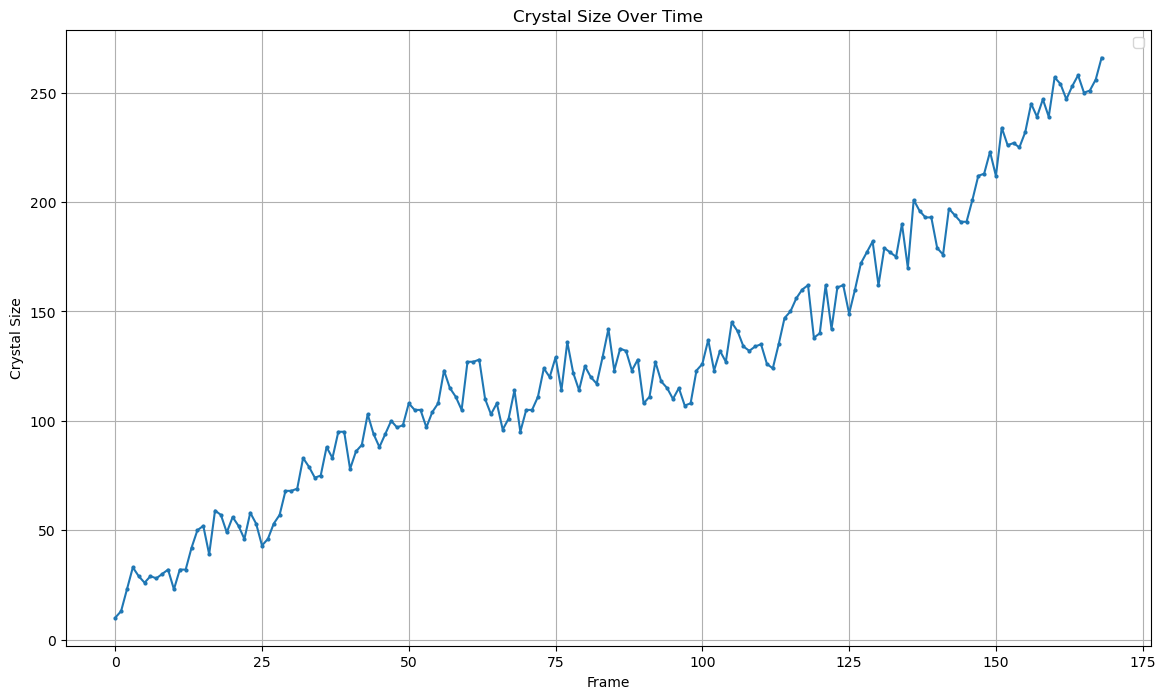

In [69]:
plt.figure(figsize=(14, 8))  # Create the figure once

plt.plot(crystal_sizes, marker='o', linestyle='-', markersize=2)

plt.title('Crystal Size Over Time')
plt.xlabel('Frame')
plt.ylabel('Crystal Size')
plt.grid(True)
plt.legend()

plt.show()

# Calculate Droplet Sizes Over Time

The same method for identifying crystals can be used to identify droplets. We simply perform the DFS clustering algorithm on the atoms that are not considered crystalline (lq6_value < lq6_cutoff).

In [ ]:
#Load the trajecory
topology_file = 'Trajectories/TPS/TPS_MC1_cont2_decor_1.gro'  
trajectory_file = 'Trajectories/TPS/TPS_MC1_cont2_decor_1.xtc'  

min_frame = 0
max_frame = 240
stride = 1

lq6_cutoff = 0.5
d_cutoff = 0.6

#Compute Crystal sizes for trajectory
droplet_sizes = calculate_droplet_sizes(topology_file, trajectory_file, min_frame, max_frame, stride, lq6_cutoff, d_cutoff, PBC=True, num_workers=8)


  0%|          | 0/240 [00:00<?, ?it/s]

In [ ]:
#Alternatively, pre-computed droplet sizes can be loaded
for i in range(1,11):
    droplet_size = np.load('gamma_glycine_crystal_3_2_3_box_5.0_1.8nm_sphere_insert_solv_minim_npteq300K_md_crystal_sizes.npy')
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


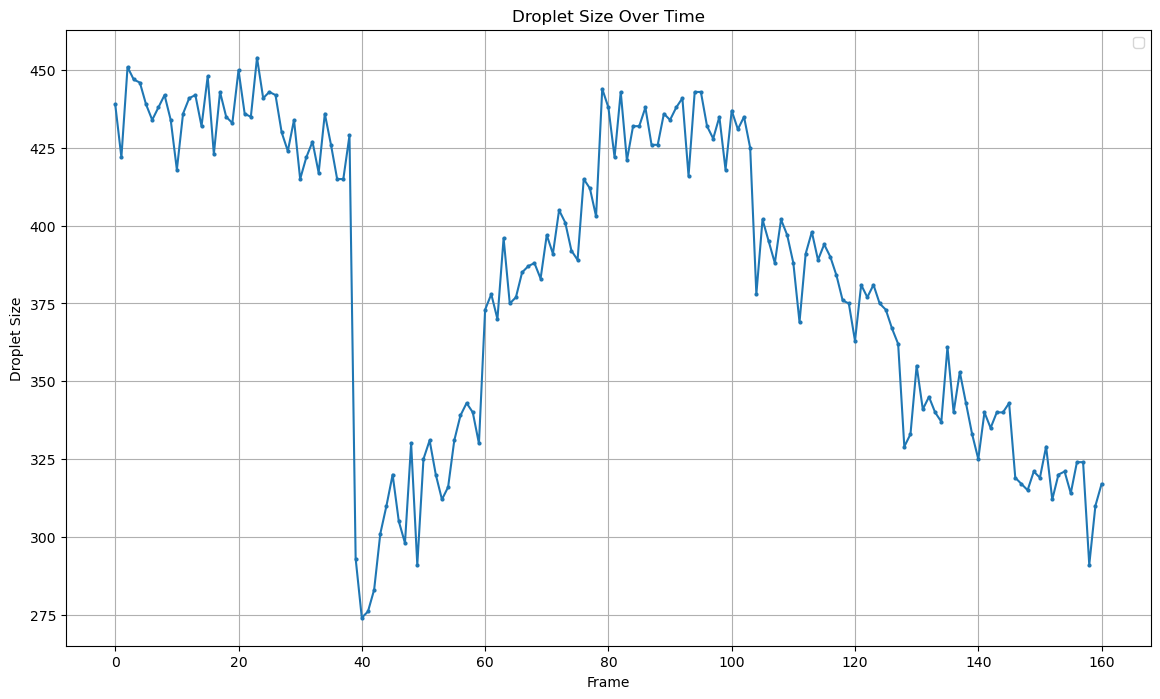

In [58]:
plt.figure(figsize=(14, 8))  # Create the figure once

plt.plot(droplet_sizes, marker='o', linestyle='-', markersize=2)

plt.title('Droplet Size Over Time')
plt.xlabel('Frame')
plt.ylabel('Droplet Size')
plt.grid(True)
plt.legend()

plt.show()

In [6]:
import numpy as np
import plotly.graph_objs as go
import matplotlib.pyplot as plt

def plot_atoms_categories(coordinates, crystal_array, droplet_array, x, filename="", interactive=True):
    """
    Plots a set of coordinates and colors them based on whether they belong to crystal, droplet, or liquid.

    Arguments:
        coordinates: np.ndarray of shape (3, N) for atom positions (X, Y, Z).
        crystal_array: list or array of indices indicating atoms classified as crystals.
        droplet_array: list or array of indices indicating atoms classified as droplets.
        x: int, number of atoms to include in the plot.
        filename: str, filename to save the plot (optional).
        interactive: bool, whether to create an interactive plot (True) or static (False).
    """
    # Slice the coordinates to the first 'x' atoms
    coordinates = coordinates[:, :x]

    # Create an array for atom categories: 0 = liquid, 1 = crystal, 2 = droplet
    categories = np.zeros(coordinates.shape[1], dtype=int)
    categories[crystal_array] = 1  # Mark crystals
    categories[droplet_array] = 2  # Mark droplets

    # Define colors for each category
    color_map = {0: 'blue', 1: 'red', 2: 'green'}  # Liquid = blue, Crystal = red, Droplet = green
    colors = np.array([color_map[cat] for cat in categories])

    if interactive:
        # Create a 3D scatter plot using Plotly
        scatter = go.Scatter3d(
            x=coordinates[0],
            y=coordinates[1],
            z=coordinates[2],
            mode='markers',
            marker=dict(
                size=7,
                color=categories,  # Color by category
                colorscale=[(0, 'blue'), (0.5, 'red'), (1, 'green')],  # Define colorscale
                colorbar=dict(
                    title='Category',
                    tickvals=[0, 1, 2],
                    ticktext=['Liquid', 'Crystal', 'Droplet'],
                    len=0.7,
                    thickness=15
                ),
                opacity=0.8
            )
        )

        layout = go.Layout(
            scene=dict(
                xaxis_title='X',
                yaxis_title='Y',
                zaxis_title='Z',
                aspectmode='cube'
            ),
            width=800,
            height=600,
            margin=dict(l=0, r=0, b=0, t=0)
        )

        fig = go.Figure(data=[scatter], layout=layout)

        if filename:
            fig.write_image(f"{filename}.svg")

        fig.show()

    else:
        # Static plot using Matplotlib
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Plot each category separately
        for cat, label, color in zip([0, 1, 2], ['Liquid', 'Crystal', 'Droplet'], ['blue', 'red', 'green']):
            mask = categories == cat
            ax.scatter(
                coordinates[0, mask],
                coordinates[1, mask],
                coordinates[2, mask],
                c=color,
                s=40,
                label=label,
                depthshade=False
            )

        ax.set_xlabel("X", weight='bold')
        ax.set_ylabel("Y", weight='bold')
        ax.set_zlabel("Z", weight='bold')
        ax.set_box_aspect([1, 1, 1])
        # plt.legend(loc='upper left')

        if filename:
            plt.savefig(f"{filename}", format='png', dpi=300, bbox_inches='tight')

        plt.show()


In [23]:
#Load the trajecory
topology_file = 'Trajectories/TPS/TPS_MC1_cont2_decor_2.gro'  # or .pdb, .tpr, etc.
trajectory_file = 'Trajectories/TPS/TPS_MC1_cont2_decor_2.xtc'  # or .trr, etc.

#Load specific frame for trajectory
frame_number = 240
lq6_cutoff = 0.5
d_cutoff = 0.6

#Extract the coordinates of CA atom for this frame
coords, box = load_coordinates(topology_file, trajectory_file, frame_number)

#Get the periodic pairwise distances between atoms matrix
dist_matrix = pbc_distance_matrix(coords.T, box)

#Create an adjacency matrix where 1 indicates distance <= cutoff, else 0
adjacency_matrix = (dist_matrix <= d_cutoff).astype(int)

#Set the diagonal to 0 (since an atom is not adjacent to itself)
np.fill_diagonal(adjacency_matrix, 0)

#Compute the neighbor vectors for each atom
neighbor_vectors = compute_neighbor_vectors(coords.T, box, adjacency_matrix)

#Compute Q6 for each atom
q6_vectors= compute_q6(neighbor_vectors)

#Compute Local Q6 for each atom
local_q6_values = compute_local_q6(q6_vectors, adjacency_matrix, dist_matrix, d_cutoff)

#Select only atoms for which lq6 is high enough
crystal_cutoff = np.where(local_q6_values > lq6_cutoff, 1, 0)
droplet_cutoff = np.where(local_q6_values < lq6_cutoff, 1, 0)

#Remove atoms from adjacency matrix that are not crystalline (select crystal neighbors)
crystal_filter = np.outer(crystal_cutoff, crystal_cutoff)
crystal_matrix = adjacency_matrix * crystal_filter

droplet_filter = np.outer(droplet_cutoff, droplet_cutoff)
droplet_matrix = adjacency_matrix * droplet_filter

#Find clusters within connected crystal atoms
crystal_clusters = find_clusters(crystal_matrix)
# cluster_array = np.zeros(558, dtype=int)
crystal_array = max(crystal_clusters, key=len)

#Find clusters within connected crystal atoms
droplet_clusters = find_clusters(droplet_matrix)
# cluster_array = np.zeros(558, dtype=int)
droplet_array = max(droplet_clusters, key=len)


# Plot interactively
plot_atoms_categories(coords, crystal_array, droplet_array, x=558, interactive=True)



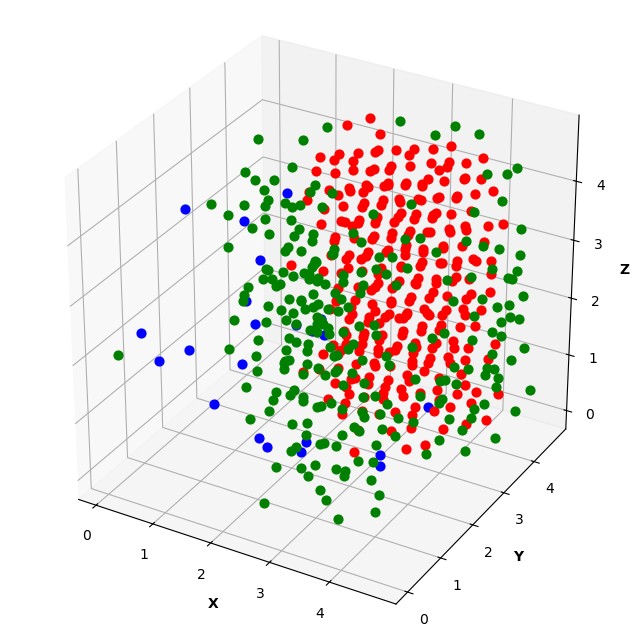

In [24]:
# Plot statically
plot_atoms_categories(coords, crystal_array, droplet_array, x=588, interactive=False, filename=f"TPS_MC1_cont2_decor_2_t{frame_number}")

# Polymorph Analysis

In [2]:
#Load the trajecory
topology_file = 'Trajectories/TPS/TPS_MC1_cont2_decor_2.gro'  
trajectory_file = 'Trajectories/TPS/TPS_MC1_cont2_decor_2.xtc' 

#Load specific frame for trajectory
frame_number = 240
lq6_cutoff = 0.5
d_cutoff = 0.6

# #Extract the coordinates of CA atom for this frame
coords, box = load_coordinates(topology_file, trajectory_file, frame_number)

#Get the periodic pairwise distances between atoms matrix
dist_matrix = pbc_distance_matrix(coords.T, box)

#Create an adjacency matrix where 1 indicates distance <= cutoff, else 0
adjacency_matrix = (dist_matrix <= d_cutoff).astype(int)

#Set the diagonal to 0 (since an atom is not adjacent to itself)
np.fill_diagonal(adjacency_matrix, 0)

#Compute the neighbor vectors for each atom
neighbor_vectors = compute_neighbor_vectors(coords.T, box, adjacency_matrix)

#Compute Q6 for each atom
q6_vectors= compute_q6(neighbor_vectors)

#Compute Local Q6 for each atom
local_q6_values = compute_local_q6(q6_vectors, adjacency_matrix, dist_matrix, d_cutoff)

#Select only atoms for which lq6 is high enough
values_cutoff = np.where(local_q6_values > lq6_cutoff, 1, 0)

#Remove atoms from adjacency matrix that are not crystalline (select crystal neighbors)
crystal_filter = np.outer(values_cutoff, values_cutoff)
crystal_matrix = adjacency_matrix * crystal_filter

#Find clusters within connected crystal atoms
clusters = find_clusters(crystal_matrix)
cluster_array = np.zeros(558, dtype=int)
largest_cluster = max(clusters, key=len)

In [3]:
import numpy as np
import plotly.graph_objects as go
import MDAnalysis as mda
# Load the trajectory and topology
u = mda.Universe(topology_file, trajectory_file)
u.trajectory[frame_number]

# Convert 'largest_cluster' to a set for faster lookup
largest_cluster_set = set(largest_cluster)

vectors = []  # Initialize the list to store vectors

# Get the box lengths (assuming orthorhombic box)
box_lengths = u.dimensions[:3]

# Loop over GLY residues
for residue in u.select_atoms('resname GLY').residues:
    # Check if the residue's 'resid' is in 'largest_cluster'
    if residue.resid in largest_cluster_set:
        C_atom = residue.atoms.select_atoms('name C')
        N_atom = residue.atoms.select_atoms('name N')
        if len(C_atom) > 0 and len(N_atom) > 0:
            origin = C_atom.positions[0]
            end = N_atom.positions[0]
            vector = end - origin  # Compute the vector without applying PBC

            # Check if vector crosses the boundary in any dimension
            crosses_boundary = False
            for i in range(3):
                if abs(vector[i]) > 0.5 * box_lengths[i]:
                    crosses_boundary = True
                    break  # No need to check other dimensions

            if not crosses_boundary:
                # Vector does not cross boundary; include it
                vectors.append((origin, end))
            else:
                # Vector crosses boundary; exclude it
                pass  # Do nothing

# Process your vector data for plotting
x_lines = []
y_lines = []
z_lines = []
x_end = []
y_end = []
z_end = []

for origin, end in vectors:
    # Line from origin to end
    x_lines.extend([origin[0], end[0], None])
    y_lines.extend([origin[1], end[1], None])
    z_lines.extend([origin[2], end[2], None])
    
    # End points for arrowheads (optional)
    x_end.append(end[0])
    y_end.append(end[1])
    z_end.append(end[2])

# Create the figure
fig = go.Figure()

# Add vector lines
fig.add_trace(go.Scatter3d(
    x=x_lines,
    y=y_lines,
    z=z_lines,
    mode='lines',
    line=dict(color='blue', width=4),
    name='Vectors'
))

# Add markers at the end points for arrowheads (optional)
fig.add_trace(go.Scatter3d(
    x=x_end,
    y=y_end,
    z=z_end,
    mode='markers',
    marker=dict(size=3, color='red', symbol='circle'),
    name='Arrowheads'
))

# Update the layout
fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis',
        aspectratio=dict(x=1, y=1, z=1)
    ),
    title='Interactive 3D Quiver Plot'
)

# Show the plot
fig.show()


In [11]:
import numpy as np
import plotly.graph_objects as go
import MDAnalysis as mda

# Convert 'largest_cluster' to a set for faster lookup
largest_cluster_set = set(largest_cluster)

vectors = []  # Initialize the list to store vectors

# Get the box lengths (assuming orthorhombic box)
box_lengths = u.dimensions[:3]

# Loop over GLY residues
for residue in u.select_atoms('resname GLY').residues:
    # Check if the residue's 'resid' is in 'largest_cluster'
    if residue.resid in largest_cluster_set:
        C_atom = residue.atoms.select_atoms('name CA')
        N_atom = residue.atoms.select_atoms('name HA2')
        if len(C_atom) > 0 and len(N_atom) > 0:
            origin = C_atom.positions[0]
            end = N_atom.positions[0]
            vector = end - origin  # Compute the vector without applying PBC

            # Check if vector crosses the boundary in any dimension
            crosses_boundary = False
            for i in range(3):
                if abs(vector[i]) > 0.5 * box_lengths[i]:
                    crosses_boundary = True
                    break  # No need to check other dimensions

            if not crosses_boundary:
                # Vector does not cross boundary; include it
                vectors.append((origin, end))
            else:
                # Vector crosses boundary; exclude it
                pass  # Do nothing

# Process your vector data for plotting
x_lines = []
y_lines = []
z_lines = []
x_end = []
y_end = []
z_end = []

for origin, end in vectors:
    # Line from origin to end
    x_lines.extend([origin[0], end[0], None])
    y_lines.extend([origin[1], end[1], None])
    z_lines.extend([origin[2], end[2], None])
    
    # End points for arrowheads (optional)
    x_end.append(end[0])
    y_end.append(end[1])
    z_end.append(end[2])

# Create the figure
fig = go.Figure()

# Add vector lines
fig.add_trace(go.Scatter3d(
    x=x_lines,
    y=y_lines,
    z=z_lines,
    mode='lines',
    line=dict(color='blue', width=4),
    name='Vectors'
))

# Add markers at the end points for arrowheads (optional)
fig.add_trace(go.Scatter3d(
    x=x_end,
    y=y_end,
    z=z_end,
    mode='markers',
    marker=dict(size=3, color='red', symbol='circle'),
    name='Arrowheads'
))

# Update the layout
fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis',
        aspectratio=dict(x=1, y=1, z=1)
    ),
    title='Interactive 3D Quiver Plot'
)

# Show the plot
fig.show()


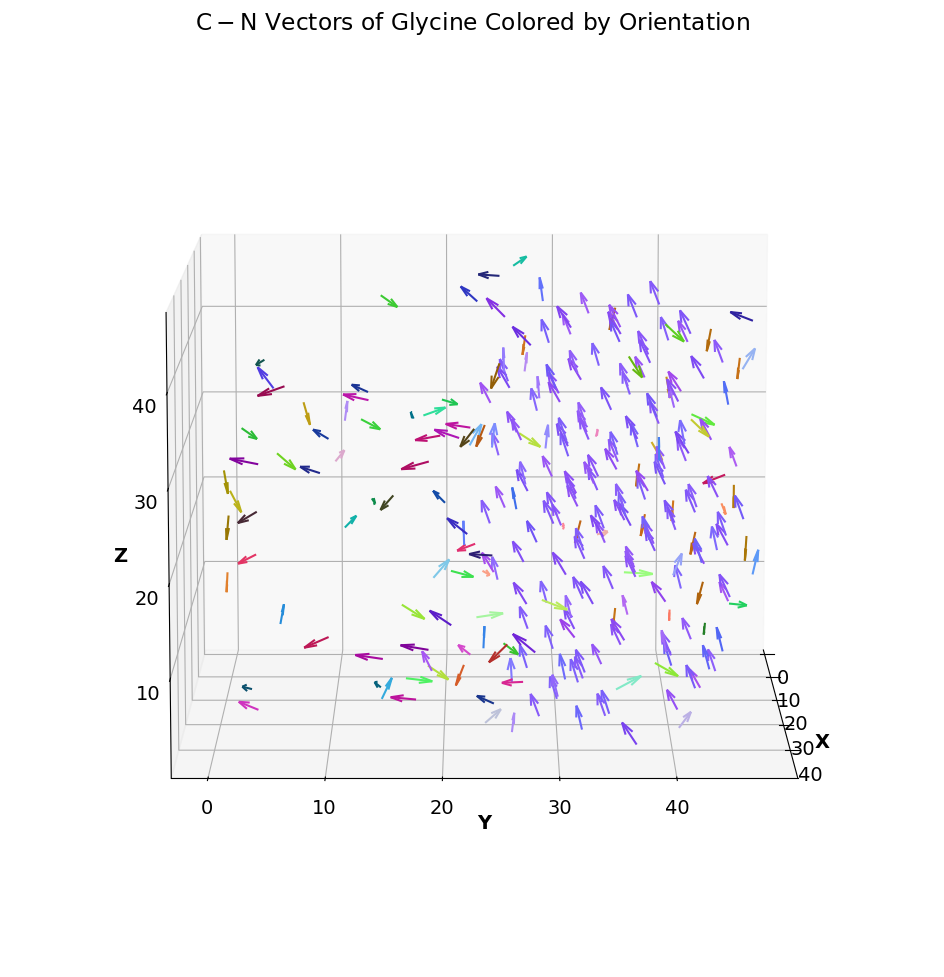

In [48]:
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the trajectory and topology
u = mda.Universe(topology_file, trajectory_file)
u.trajectory[frame_number]

largest_cluster_set = set(largest_cluster)
vectors = []
box_lengths = u.dimensions[:3]

# Collect valid vectors
for residue in u.select_atoms('resname GLY').residues:
    if residue.resid in largest_cluster_set:
        C_atom = residue.atoms.select_atoms('name C')
        N_atom = residue.atoms.select_atoms('name N')
        if len(C_atom) > 0 and len(N_atom) > 0:
            origin = C_atom.positions[0]
            end = N_atom.positions[0]
            vector = end - origin
            # Check boundaries
            if not any(abs(vector[i]) > 0.5 * box_lengths[i] for i in range(3)):
                vectors.append((origin, end))

# Extract origins and vector components
origins_x = [v[0][0] for v in vectors]
origins_y = [v[0][1] for v in vectors]
origins_z = [v[0][2] for v in vectors]

dx = [v[1][0] - v[0][0] for v in vectors]
dy = [v[1][1] - v[0][1] for v in vectors]
dz = [v[1][2] - v[0][2] for v in vectors]

# Convert each vector to a color based on its 3D direction
colors = []
for i in range(len(dx)):
    vec = np.array([dx[i], dy[i], dz[i]])
    norm = np.linalg.norm(vec)
    if norm != 0:
        u = vec / norm  # Unit direction vector
    else:
        u = np.array([0.0, 0.0, 0.0])  # handle zero-length vector

    # Map from [-1,1] to [0,1]
    r = (u[0] + 1) / 2
    g = (u[1] + 1) / 2
    b = (u[2] + 1) / 2
    colors.append((r, g, b))

plt.rcParams.update({'font.size': 14})

# Create the figure and 3D axis
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each arrow individually with its unique RGB color
for i in range(len(origins_x)):
    ax.quiver(origins_x[i], origins_y[i], origins_z[i],
              dx[i], dy[i], dz[i],
              arrow_length_ratio=0.5,
              color=colors[i])

# Set axis labels and title
ax.set_xlabel('X', fontweight='bold')
ax.set_ylabel('Y', fontweight='bold')
ax.set_zlabel('Z', fontweight='bold')
ax.set_title(r'$\mathrm{C-N}$ Vectors of Glycine Colored by Orientation', pad=10)

# Adjust the view if desired
ax.view_init(elev=10, azim=360)

# Adjust subplot spacing
plt.tight_layout()  
# or you can use:
# fig.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95)

# Save the figure with a tight bounding box
plt.savefig("Figures/Vector_orientations_360_view.svg", dpi=300, bbox_inches='tight')

plt.show()


# Crystal, Droplet, Liquid Movie

In [4]:
import os
import imageio
import matplotlib.pyplot as plt

def plot_atoms_categories(coordinates, crystal_array, droplet_array, x, filename="", interactive=True):
    coordinates = coordinates[:, :x]

    # Category assignment
    categories = np.zeros(coordinates.shape[1], dtype=int)
    categories[crystal_array] = 1
    categories[droplet_array] = 2

    # Color mapping
    color_map = {0: 'blue', 1: 'red', 2: 'green'}

    if interactive:
        # Interactive Plotly (no changes needed if you're not using these images)
        pass
    else:
        # Static matplotlib plot
        # Set a fixed figure size and remove bbox_inches='tight'
        fig = plt.figure(figsize=(8,10))
        ax = fig.add_subplot(111, projection='3d')

        # Optional: fix axis limits (adjust as needed)
        ax.set_xlim(0, 5)
        ax.set_ylim(0, 5)
        ax.set_zlim(0, 5)

        # Plot each category separately with fixed sizes and no dynamic changes
        for cat, label, color in zip([0, 1, 2], ['Liquid', 'Crystal', 'Droplet'], ['blue', 'red', 'green']):
            mask = categories == cat
            ax.scatter(
                coordinates[0, mask],
                coordinates[1, mask],
                coordinates[2, mask],
                c=color,
                s=40,
                label=label,
                depthshade=False
            )

        ax.set_xlabel("X", weight='bold')
        ax.set_ylabel("Y", weight='bold')
        ax.set_zlabel("Z", weight='bold')

        # Remove legend or keep it fixed without tight layout
        # ax.legend(loc='upper left')

        # Draw the canvas before saving to ensure no resizing
        fig.canvas.draw()

        if filename:
            fig.savefig(filename, format='png', dpi=300)  # No bbox_inches='tight'

        plt.close(fig)


# Input files
topology_file = 'Trajectories/TPS/TPS_MC1_cont_decor_1.gro'  # or .pdb, .tpr, etc.
trajectory_file = 'Trajectories/TPS/TPS_MC1_cont_decor_1.xtc'  # or .trr, etc.

# Parameters
lq6_cutoff = 0.5
d_cutoff = 0.6
start_frame = 0
end_frame = 169  # Adjust as needed
output_dir = "frames"

# Create a directory for the frames if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

filenames = []

for frame_number in range(start_frame, end_frame + 1):
    # Load coordinates and box
    coords, box = load_coordinates(topology_file, trajectory_file, frame_number)

    # Compute distances and adjacency
    dist_matrix = pbc_distance_matrix(coords.T, box)
    adjacency_matrix = (dist_matrix <= d_cutoff).astype(int)
    np.fill_diagonal(adjacency_matrix, 0)

    # Compute neighbor vectors and q6 values
    neighbor_vectors = compute_neighbor_vectors(coords.T, box, adjacency_matrix)
    q6_vectors = compute_q6(neighbor_vectors)
    local_q6_values = compute_local_q6(q6_vectors, adjacency_matrix, dist_matrix, d_cutoff)

    # Determine crystal vs droplet atoms
    crystal_cutoff = np.where(local_q6_values > lq6_cutoff, 1, 0)
    droplet_cutoff = np.where(local_q6_values < lq6_cutoff, 1, 0)

    # Filter adjacency for crystal and droplet
    crystal_filter = np.outer(crystal_cutoff, crystal_cutoff)
    crystal_matrix = adjacency_matrix * crystal_filter

    droplet_filter = np.outer(droplet_cutoff, droplet_cutoff)
    droplet_matrix = adjacency_matrix * droplet_filter

    # Find clusters
    crystal_clusters = find_clusters(crystal_matrix)
    droplet_clusters = find_clusters(droplet_matrix)

    crystal_array = max(crystal_clusters, key=len) if crystal_clusters else []
    droplet_array = max(droplet_clusters, key=len) if droplet_clusters else []

    # Plot the frame
    # Save the figure
    frame_filename = os.path.join(output_dir, f"frame_{frame_number:04d}.png")
    filenames.append(frame_filename)
    # Make sure plot_atoms_categories returns a figure or use plt.gcf() after it
    plot_atoms_categories(coords, crystal_array, droplet_array, x=558, interactive=False, filename=frame_filename)
    fig = plt.gcf()

    # # Save the figure
    # frame_filename = os.path.join(output_dir, f"frame_{frame_number:04d}.png")
    # fig.savefig(frame_filename, dpi=150)
    # plt.close(fig)
    # filenames.append(frame_filename)

# Optionally, remove the frame images after creating the GIF
# for filename in filenames:
#     os.remove(filename)


<Figure size 640x480 with 0 Axes>

In [4]:
import os
import imageio
import matplotlib.pyplot as plt


start_frame = 0
end_frame = 240  # Adjust as needed
output_dir = "frames/TPS_MC1_cont2_decor_2"

# Create a GIF from the saved frames
# with imageio.get_writer('movie.gif', mode='I', duration=0.1) as writer:
with imageio.get_writer('movie.mp4', fps=10, codec='libx264') as writer:
    for frame_number in range(start_frame, end_frame + 1):
        filename = os.path.join(output_dir, f"frame_{frame_number:04d}.png")
        image = imageio.imread(filename)
        # print(image.shape)
        writer.append_data(image)


/tmp/ipykernel_63621/4066457021.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2400, 3000) to (2400, 3008) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
